# Try to use delay embedding to the simple system dynamics

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import chirp
from functools import partial # Import this due to weird lambda behavior
import system_dynamics
import networks
from importlib import reload
%load_ext tensorboard

## Training data generation

In [155]:
t0 = 0
t1 = 20
dt = 0.01
ts_steps = np.arange(t0, t1, dt)
ts_longer = np.arange(t0, t1, 5*dt)
u_func_list = [
    # High-freq inputs
    partial(chirp, f0=0.9, f1=1.1, t1=1),
    partial(chirp, f0=0.5, f1=1.4, t1=1),
    lambda t : np.sin(0.5*t+1.2),
    interp1d( ts_steps, np.random.normal(0, 5, ts_steps.shape), fill_value="extrapolate", kind='cubic'),
#     interp1d( ts_steps, np.random.normal(0, 5, ts_steps.shape), fill_value="extrapolate", kind='cubic'),
    # Low-freq inputs
#     partial(chirp, f0=0.2, f1=0.5, t1=1),
#     lambda t : np.sin(0.04*t+1.2),
#     interp1d( ts_longer, np.random.normal(0, 0.2, ts_longer.shape), fill_value="extrapolate", kind='cubic'),
#     interp1d( ts_longer, np.random.normal(0, 0.5, ts_longer.shape), fill_value="extrapolate", kind='cubic')
]
u_names = ['Chirp_thin', 'chirp_wide', 'sin', 'rand_var5']

duffing_sys = system_dynamics.Duffing(t0=t0, tf=t1, dt=dt, noise=0)
duffing_full_sys = system_dynamics.DuffingFullState(t0=t0, tf=t1, dt=dt, noise=0)
fma_sys = system_dynamics.Fma(t0=t0, tf=t1, dt=dt, noise=0)
sys_list = [duffing_sys, duffing_full_sys, fma_sys]
sys_names = ['Duffing original', 'Duffing full state', 'Fma full state']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list )
    syst.data_generator()


## Plot the generated data for visual inspection

<Figure size 432x288 with 0 Axes>

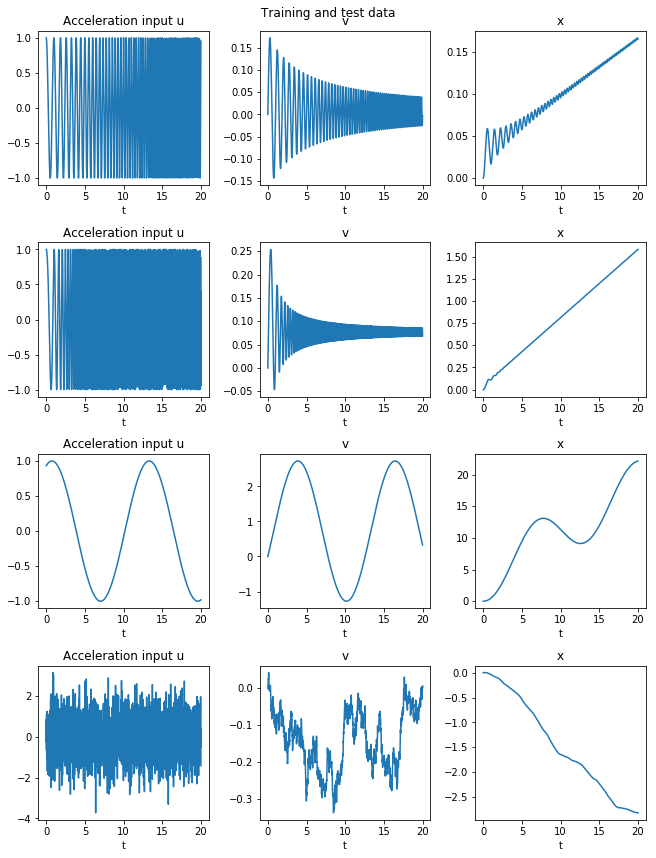

In [126]:
fig,axs = fma_sys.plot_dataset(title='Training and test data', plot_skip_rate=1)

## Generate a bunch of neural nets for learning

In [154]:
reload(system_dynamics)
reload(networks)

<module 'networks' from '/Users/zz/Documents/GT 20X/phml/NN_toy_examples/networks.py'>

In [151]:
# Set up nets
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_mask = [2,3] # Give: u-3, v-1, x-2, t-0
Nlayer = 2
Nneuron = 5
de = 5
delay_int = 1

net_list = []
for i in range(len(sys_list)):
    net_list.append(
        networks.NN_Delay(
            sys_list[i], input_mask, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=True,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg, 
            de=de, delay_int=delay_int
        )
    )
net_names = [ name+'-{0}-{1}'.format(Nlayer, Nneuron) for name in sys_names]

# Construct models
for nn in net_list:
    nn.construct()


In [152]:
# Train models. 
Epoch = 250
for nn in net_list:
    nn.train(epoch=Epoch, inds=[3]) # inds is the dataset selected for training
    nn.summary()

Train on 1996 samples
Epoch 1/250
1996/1996 [==============================] - 1s 375us/sample - loss: 1.7781
Epoch 2/250
1996/1996 [==============================] - 0s 51us/sample - loss: 1.2511
Epoch 3/250
1996/1996 [==============================] - 0s 51us/sample - loss: 1.0730
Epoch 4/250
1996/1996 [==============================] - 0s 46us/sample - loss: 1.0037
Epoch 5/250
1996/1996 [==============================] - 0s 47us/sample - loss: 0.9658
Epoch 6/250
1996/1996 [==============================] - 0s 49us/sample - loss: 0.9374
Epoch 7/250
1996/1996 [==============================] - 0s 37us/sample - loss: 0.9063
Epoch 8/250
1996/1996 [==============================] - 0s 39us/sample - loss: 0.8693
Epoch 9/250
1996/1996 [==============================] - 0s 38us/sample - loss: 0.8220
Epoch 10/250
1996/1996 [==============================] - 0s 37us/sample - loss: 0.7599
Epoch 11/250
1996/1996 [==============================] - 0s 36us/sample - loss: 0.6795
Epoch 12/250
1996/

ValueError: A target array with shape (1996, 1, 1) was passed for an output of shape (None, 2, 1) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.

In [117]:
# Save models
for i in range(len(net_list)):
    net_list[i].save(net_names[i]+'-tanh-ux-models{0}'.format(i))

INFO:tensorflow:Assets written to: Duffing original-2-5-tanh-ux-models0/model/assets
INFO:tensorflow:Assets written to: Duffing full state-2-5-tanh-ux-models1/model/assets
INFO:tensorflow:Assets written to: Fma full state-2-5-tanh-ux-models2/model/assets


In [157]:
fig,axs = plt.subplots(1, len(net_list))
for n in range(len(net_list)):
    nn = net_list[n]
    lxx = nn.plot_loss_history(axs=axs[n])
    axs[n].add_line(lxx)
plt.show()

<Figure size 432x288 with 0 Axes>

## Validation and testing

In [56]:
# Plotting helper function...
def plot_tests(test_inds, net_list, net_inds, out_list, net_names, u_names, out_names,
               datatype='traj', log_mode=False, plot_skip_rate=1, title=''):
    # Arguments:
    # test_inds: indices of test dataset to be plotted
    # net_list : neural nets (containing their own dynamics). Don't pass one in if its dynamics size is weird.
    # out_list : indices of output values you want to see. This assumes those indices apply to all dynamics.
    # datatype : Type of data that's going to be plotted
    # log_mode : whether the plots are in log scale or not
    plt.clf()
    results_list = [nn.test(inds=test_inds,squeeze=False) for nn in net_list]
    if log_mode:
        logtxt = 'log '
    else:
        logtxt = ''
    
    # datatype decides what appears on the plot
    
    Noutput = len(out_list)
    Nrow = (len(net_inds)) * Noutput # Leave the final 2 rows for aggregated plots
    Ncol = len(test_inds)
    fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (Ncol*4,Nrow*3), squeeze=False)
    figt,axst = plt.subplots(Noutput, Ncol, constrained_layout=True, figsize = (Ncol*4,Noutput*4), squeeze=False)
    
    for j in range(len(test_inds)):
        # For each test dataset (each column), plot all models' reactions
        jj = test_inds[j]
        
        # For each network, find its prediction and plot corresponding outputs
        for n in range(len(net_inds)):
            nn = net_inds[n]
            # Find its time series. 
            time_series = results_list[nn][2][jj][:,0,-1]
            # Above: [nn] - Take the nn-th network's result; [2] - The 3rd element in result is Inputset;
            #        [jj] - Take the jj-th test run's result; 
            #        [:,0,-1] means take all frames(:), first row (0, where we stored time), last value (-1),
            #          where we take the last value because that's where the output data matches.
            
            # Find the correct thing that we want to plot.
            if datatype == 'l2':
                result = np.square(results_list[nn][0][jj] - results_list[nn][1][jj])
            elif datatype == 'l1':
                result = np.abs(results_list[nn][0][jj] - results_list[nn][1][jj])
            # Don't need to do anything else when it's 'traj'.
            else:
                result = results_list[nn][0][jj]
            if log_mode:
                result = np.log(result)
            
            # Make individual plots for each output, where the indexing fun begins
            for i in range(Noutput):
                ii = out_list[i]
                # print(results_list[nn][1][jj].shape)
                # print(result.shape)
                make_axs_plot(
                    axs = axs[n + len(net_inds)*i][j], time = time_series, data = result[:,ii],
                    title = datatype+' of '+out_names[i]+'\n for '+net_names[nn]+'\n on input '+u_names[jj],
                    datatype = datatype, data2 = results_list[nn][1][jj][:,ii], 
                    leglist = [net_names[nn], 'True value'], skip = plot_skip_rate
                )
                #print(n + len(net_inds)*i, j, result[:,ii].shape)
                
                # Also draw this network's plot onto the overlay plots over all networks
                axst[i][j].plot(time_series[::plot_skip_rate], result[::plot_skip_rate,ii])
        
        for i in range(Noutput):
            axst[i][j].set_title( datatype+' of '+out_names[i]+'\n on input '+u_names[jj] )
            axst[i][j].legend(net_names)
            
#             axs[n][j].plot(time_series[::plot_skip_rate], error_g[::plot_skip_rate,0])
#             axs[n][j].set_title('Error of v for '+net_names[n]+' on input '+u_names[jj])
#             axs[n][j].set_xlabel('t')
#             axs[n+4][j].plot(time_series[::plot_skip_rate], results_list[n][0][jj][::plot_skip_rate,0])
#             axs[n+4][j].plot(time_series[::plot_skip_rate], results_list[n][1][jj][::plot_skip_rate,0])
#             axs[n+4][j].legend([net_names[n]]+['True value'])
#             axs[n+8][j].plot(time_series[::plot_skip_rate], error_g[::plot_skip_rate,1])
#             axs[n+8][j].set_title('Error of x for '+net_names[n]+' on input '+u_names[jj])
#             axs[n+8][j].set_xlabel('t')
#             axs[n+12][j].plot(time_series[::plot_skip_rate], results_list[n][0][jj][::plot_skip_rate,1])
#             axs[n+12][j].plot(time_series[::plot_skip_rate], results_list[n][1][jj][::plot_skip_rate,1])
#             axs[n+12][j].legend([net_names[n]]+['True value'])
#             axst[0][j].plot(time_series[::plot_skip_rate], result[::plot_skip_rate,ii])
#             axst[1][j].plot(time_series[::plot_skip_rate], result[::plot_skip_rate,1])
#         axs[4][j].set_title('Predicted v')
#         axs[4][j].set_xlabel('t')
#         axs[12][j].set_title('Predicted x')
#         axs[12][j].set_xlabel('t')
#         axst[0][j].set_title('Log errors of v on input '+u_names[jj])
#         axst[0][j].legend(net_names[:4])
#         axst[1][j].set_title('Log errors of x on input '+u_names[jj])
#         axst[1][j].legend(net_names[:4])
#     fig.suptitle('F=ma when given <u,v> as training input, after 1200 SGD epochs (no momentum)\n\n')
    fig.suptitle(title)
    figt.suptitle('Overlaying result for '+title)
    return fig, axs

def make_axs_plot(axs, time, data, title, datatype, data2=None, leglist=[], skip=1):
    axs.plot(time[::skip], data[::skip])
    axs.set_title(title)
    axs.set_xlabel('t')
    if datatype == 'traj':
        axs.plot(time[::skip], data2[::skip])
        axs.legend(leglist)
    return axs

In [ ]:
# Plot systems that try to learn the full state - error plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_list, net_inds=[1,2], out_list=[0,1], 
                       net_names=net_names, u_names=u_names, out_names=['v','x'],
                       datatype='l2', log_mode=True, plot_skip_rate=20, 
                       title='Delay embedding training result errors when given <u,v> as training input\n' )

<Figure size 432x288 with 0 Axes>

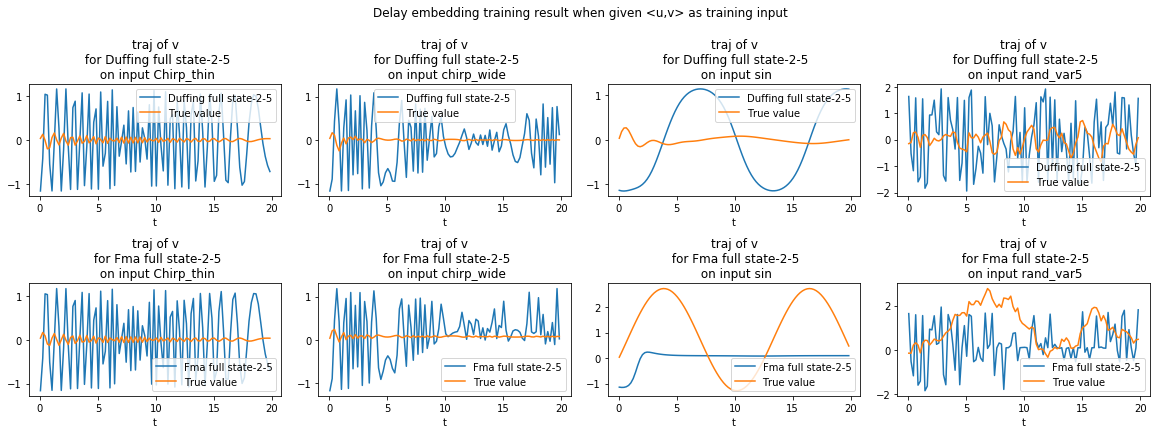

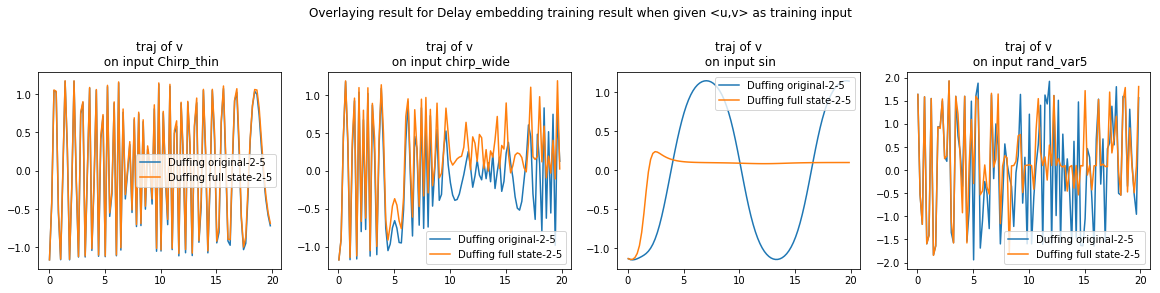

In [153]:
# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_list, net_inds=[1,2], out_list=[0,1], 
                       net_names=net_names, u_names=u_names, out_names=['v','x'],
                       datatype='traj', log_mode=False, plot_skip_rate=20, 
                       title='Delay embedding training result when given <u,v> as training input\n' )

<Figure size 432x288 with 0 Axes>

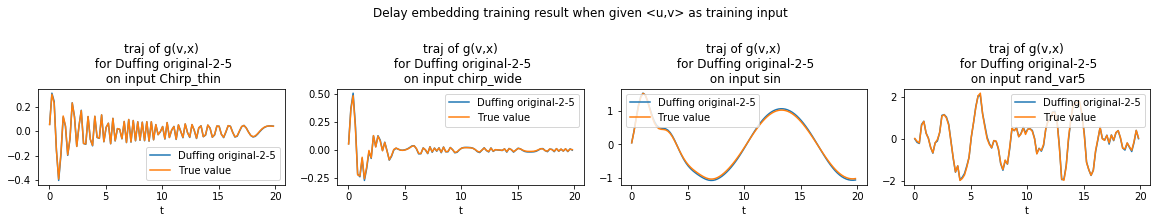

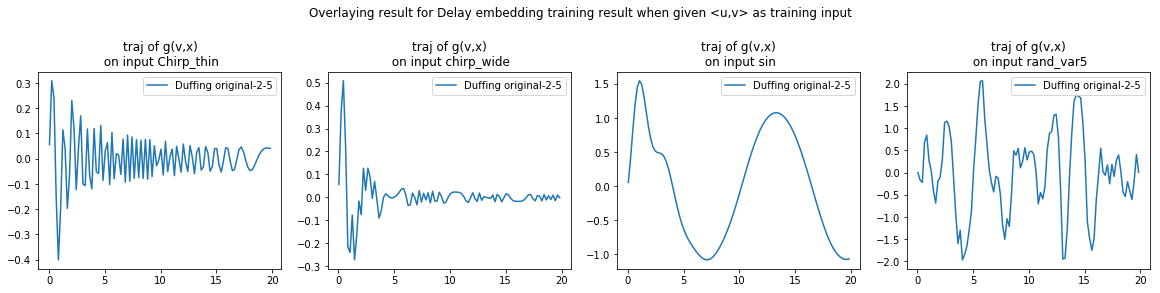

In [148]:
# Plot systems that try to learn a specific variable - trajectory plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_list, net_inds=[0], out_list=[0], 
                       net_names=net_names, u_names=u_names, out_names=['g(v,x)'],
                       datatype='traj', log_mode=False, plot_skip_rate=20, 
                       title='Delay embedding training result when given <u,v> as training input\n' )

In [ ]:
# Plot systems that try to learn a specific variable - error plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_list, net_inds=[0], out_list=[0], 
                       net_names=net_names, u_names=u_names, out_names=['g(v,x)'],
                       datatype='l2', log_mode=True, plot_skip_rate=20, 
                       title='Delay embedding training error result when given <u,v> as training input\n' )